In [12]:
!nvidia-smi

Wed Apr  6 00:31:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
!sudo apt-get install tree -qq > /dev/null

In [14]:
#install libraries
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17.3
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-jqyin4no
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-jqyin4no


**Build the Dataset**

In [58]:
# imports
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import os
import PIL

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [27]:
# our data directories
!tree weapon -L 2

weapon
├── images
│   ├── train
│   └── val
└── lables
    ├── train
    └── val

6 directories, 0 files


#Normalize the image's Bounding Box
- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1


In [34]:
!cat weapon/lables/val/1.txt

1
76 45 146 87


In [38]:
#
img = cv2.imread('/content/weapon/images/train/101.jpeg', cv2.IMREAD_UNCHANGED)
dimensions = img.shape
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (168, 300, 3)
Image Height       :  168
Image Width        :  300
Number of Channels :  3


In [72]:
# sources path
images_train_path = '/content/weapon/images/train'
images_val_path = '/content/weapon/images/val'
labels_train_path = '/content/weapon/lables/train'
labels_val_path = '/content/weapon/lables/val'

Images = []
Labels = []
Targets = []

# import the data into the lists

for path in sorted(os.listdir(images_train_path)):
    img_path = os.path.join(images_train_path, path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Images.append(img)
  
for path in sorted(os.listdir(images_val_path)):
    img_path = os.path.join(images_val_path, path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Images.append(img)

for path in sorted(os.listdir(labels_train_path)):
    label_path = os.path.join(labels_train_path, path)
    ls = None
    with open(label_path, 'r') as label_file:
        ls = label_file.read().splitlines()
    
    boxes = []
    for i in range(1, int(ls[0])+1):
        x = [int(j) for j in ls[i].split()]
        boxes.append(x)
    Labels.append(boxes)

for path in sorted(os.listdir(labels_val_path)):
    label_path = os.path.join(labels_val_path, path)
    ls = None
    with open(label_path, 'r') as label_file:
        ls = label_file.read().splitlines()
    
    boxes = []
    for i in range(1, int(ls[0])+1):
        x = [int(j) for j in ls[i].split()]
        boxes.append(x)
    Labels.append(boxes)

In [73]:
len(Images), len(Labels)

(333, 333)

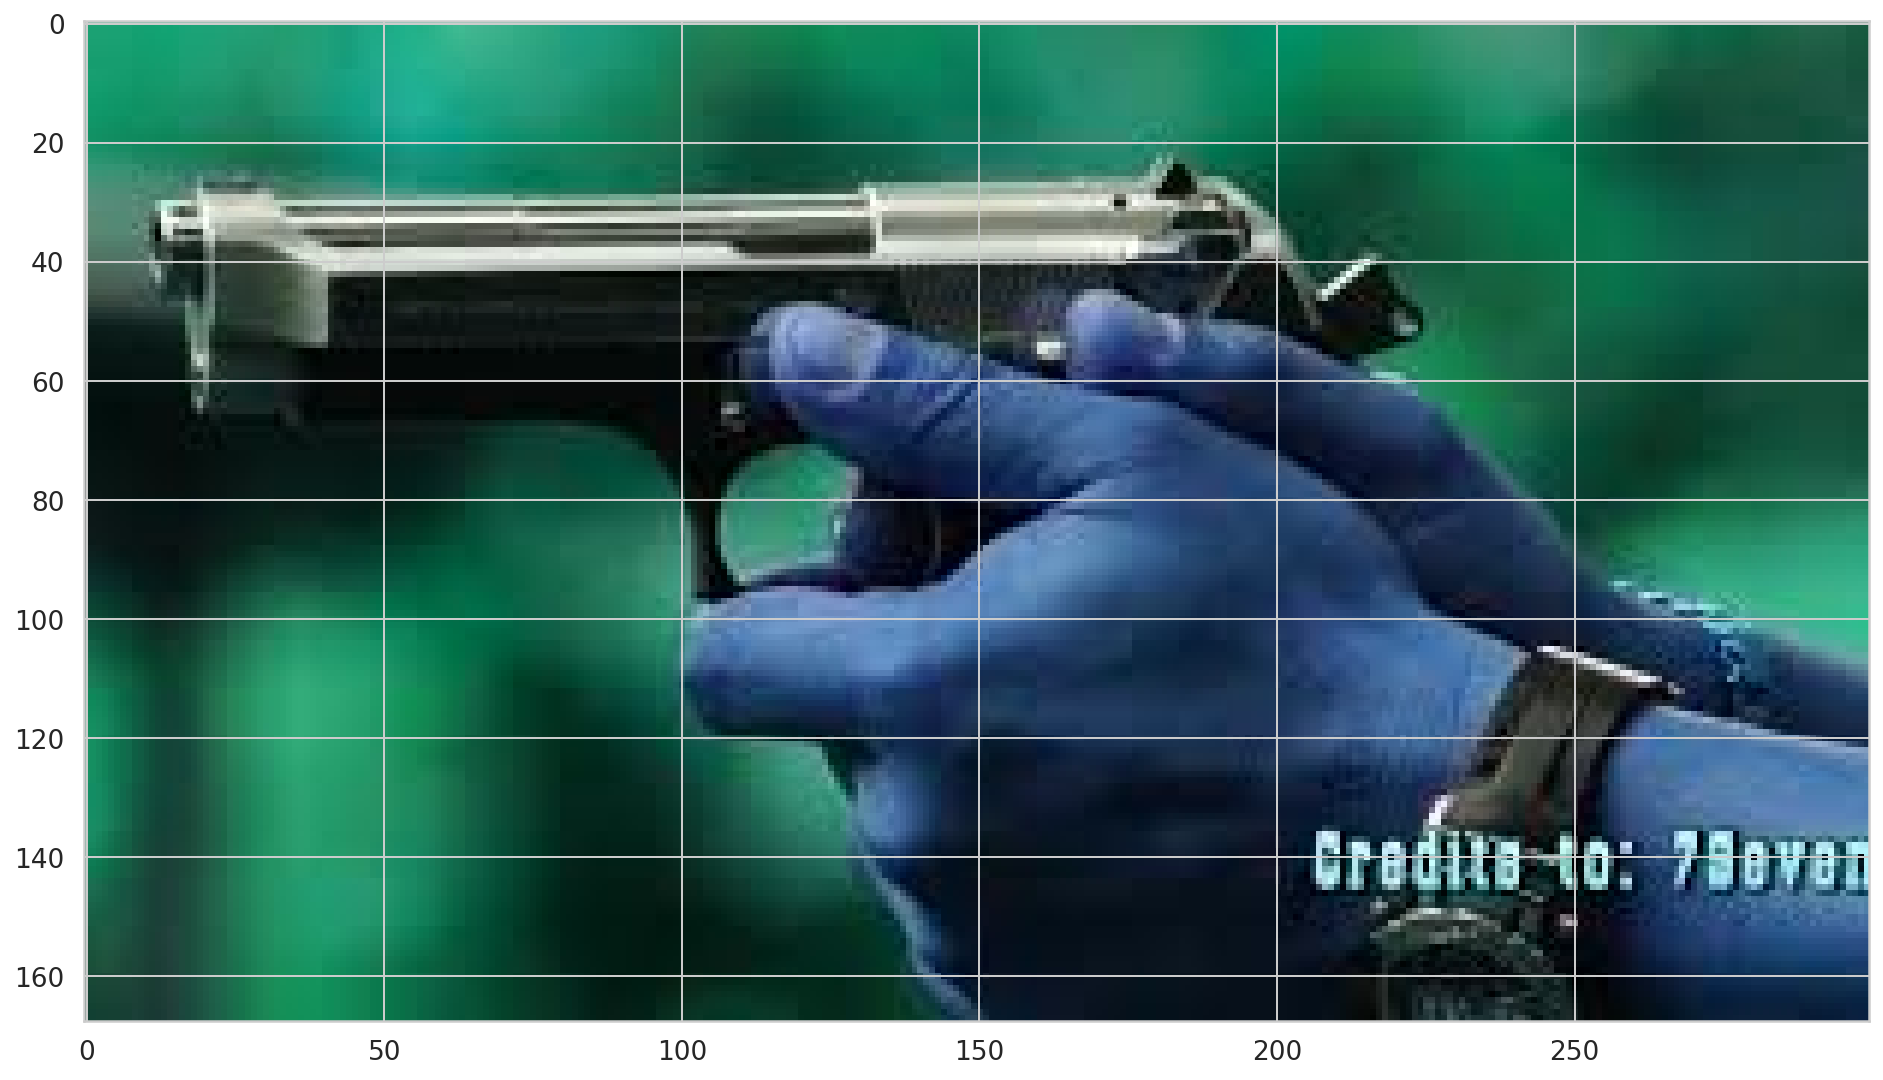

In [74]:
img = cv2.imread('/content/weapon/images/train/100.jpeg', cv2.IMREAD_UNCHANGED)
plt.imshow(img)

(168, 300, 3)


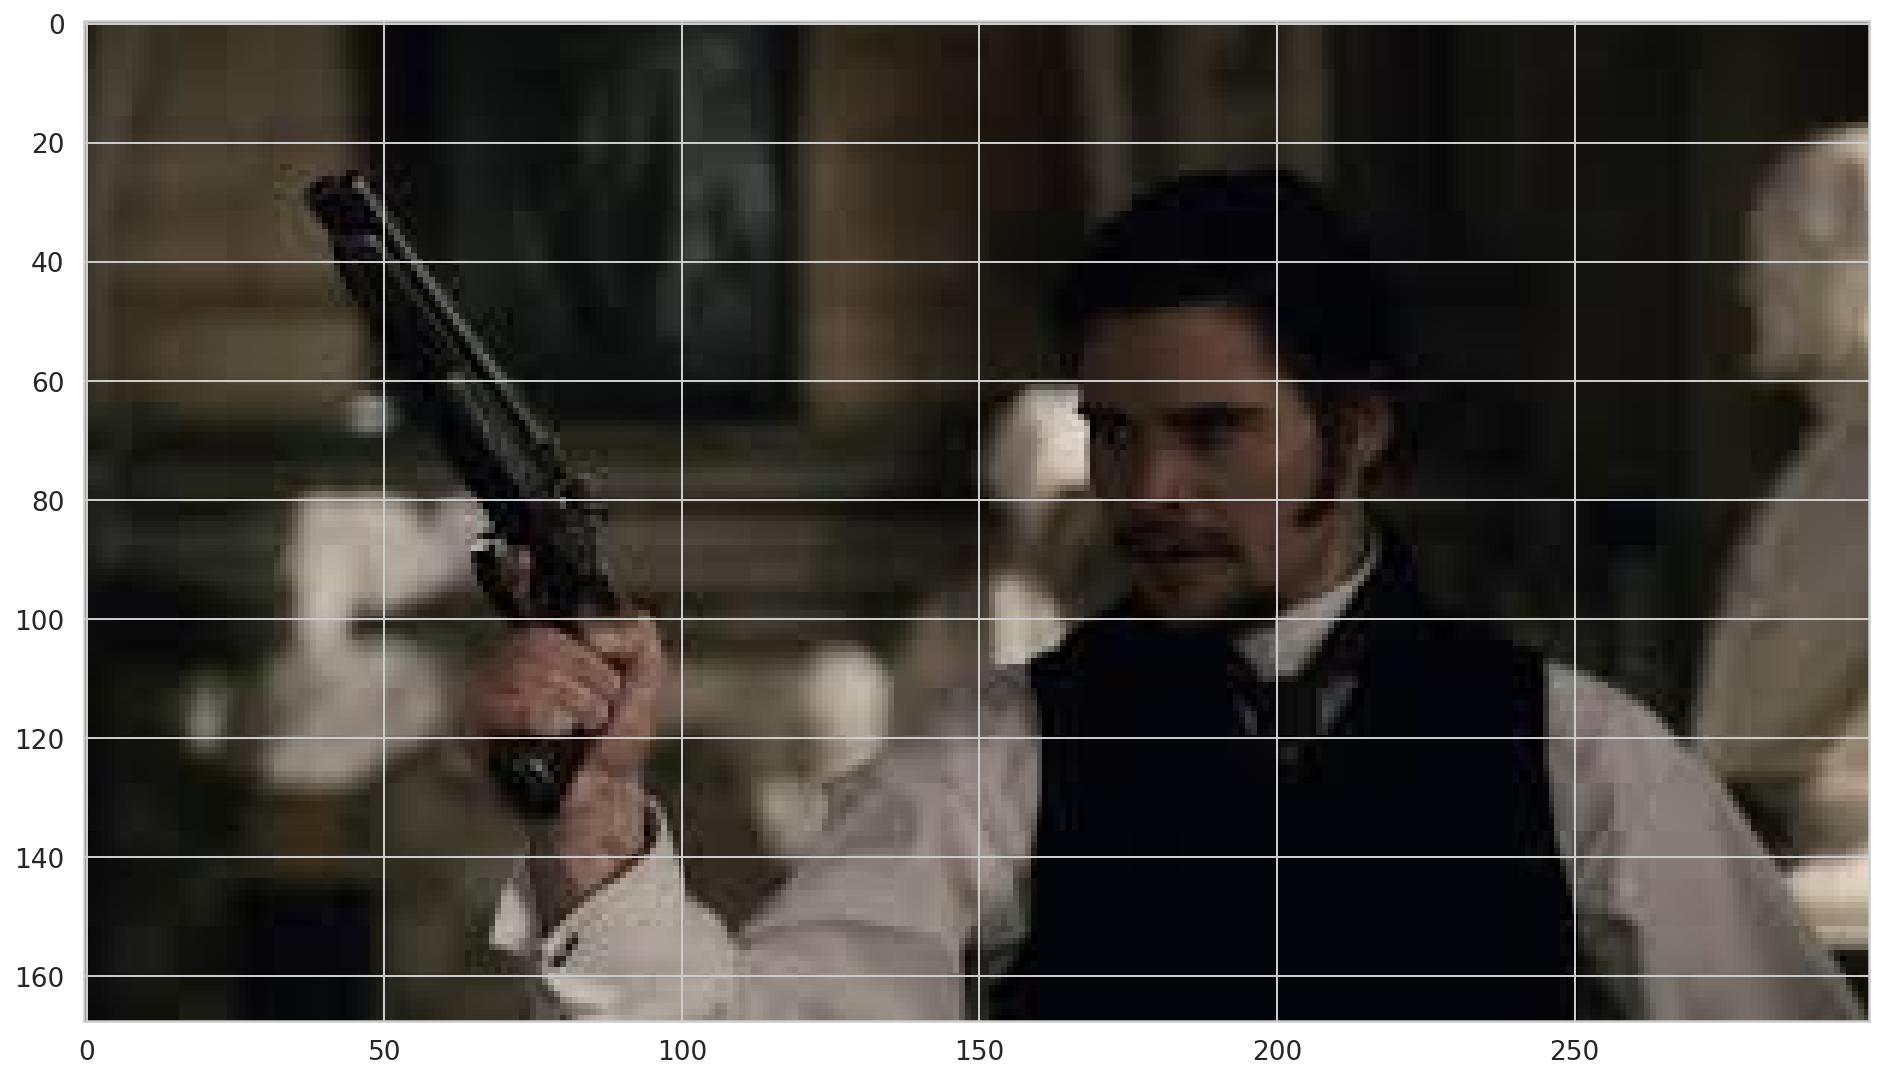

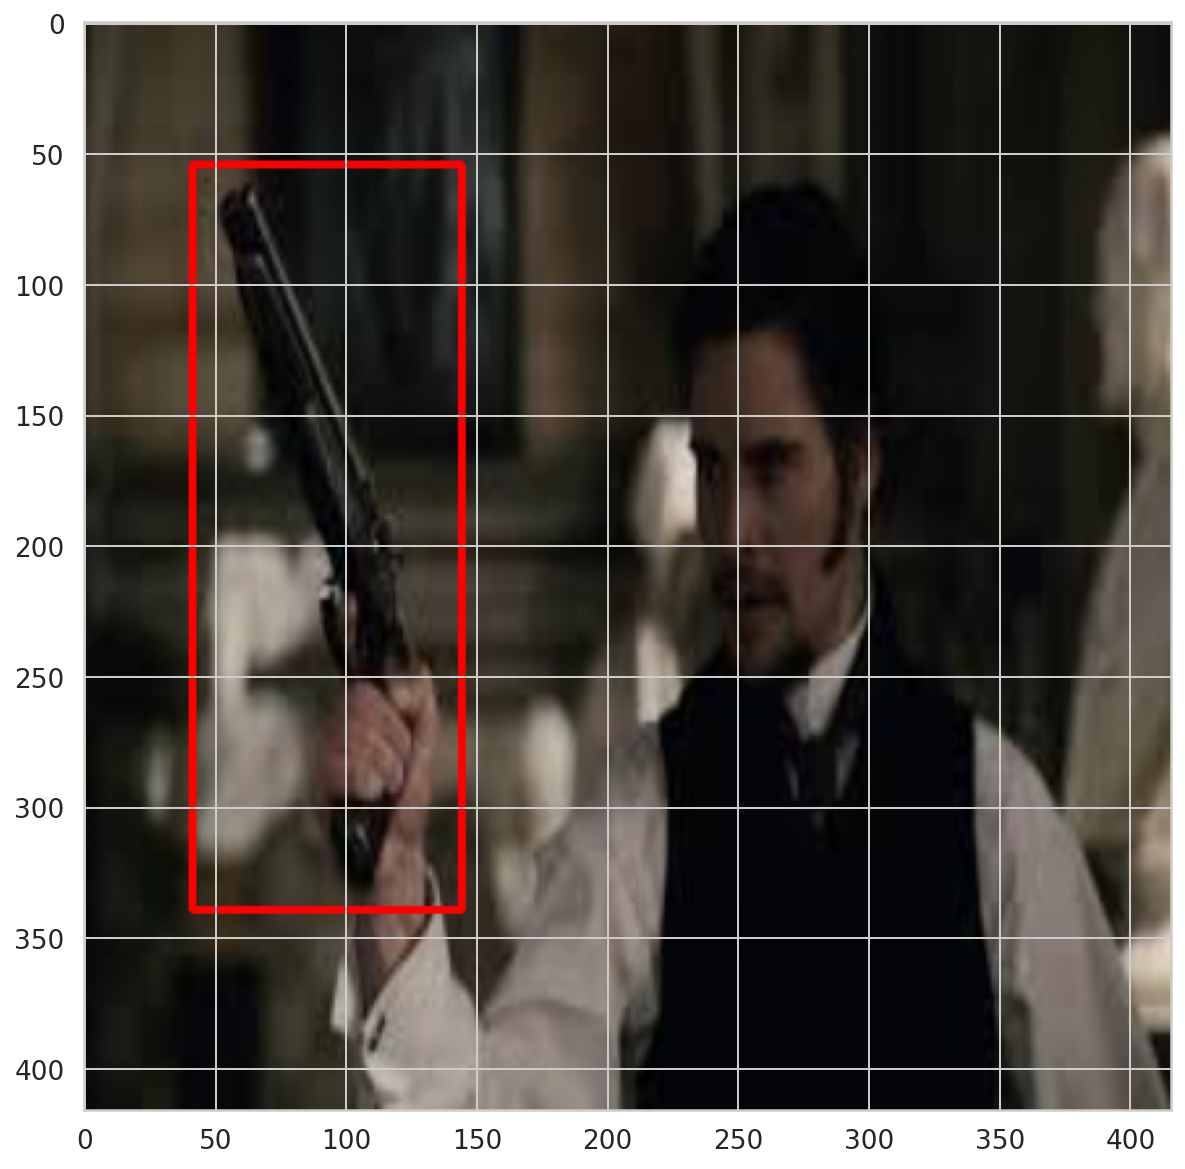

In [75]:
# change the shape of the pictures to 460x460

ls = Labels[-1]
img = Images[-1]
h, w = img.shape[:2]
print(img.shape)
# show the old version of the photo (probably not 460x460)
plt.imshow(img)
plt.show()

# resize the picture to 460x460
img = cv2.resize(img, (416, 416))
for i in range(len(ls)):
    img = cv2.rectangle(img, (int(ls[i][0] * (416/w)), int(ls[i][1] * (416/h))), (int(ls[i][2] * (416/w)), int(ls[i][3] * (416/h))), (255, 0, 0), 2)
# show the new version of the photo (460x460) and add the bounding box
plt.imshow(img)
plt.show()

# do so for each picture in the dataset
for i in range(len(Images)):
    img = Images[i]
    boxes = Labels[i]
    h, w = img.shape[:2]
    img = cv2.resize(img, (416, 416))
    Images[i] = img

    if i < 332 - 34:
      cv2.imwrite(f'/content/weapon/images_new/train/{i}.jpeg', img)
    else:
      cv2.imwrite(f'/content/weapon/images_new/val/{i}.jpeg', img)
    target = np.zeros((13, 13, 5))
    
    # update the bounding box values
    for box in boxes:
        x1, y1, x2, y2 = int(box[0]*(416/w)), int(box[1]*(416/h)), int(box[2]*(416/w)), int(box[3]*(416/h))
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
        bx, by = x2 - x1, y2 - y1
        target_input = [1, cx/416, cy/416, bx/416, by/416]
        #print(target_input)
        if i < 332 - 34:
            with open(f'/content/weapon/lables_new/train/{i}.txt', 'w') as f:
                for v in target_input:
                  f.write(str(v) + " ")
        else:
             with open(f'/content/weapon/lables_new/val/{i}.txt', 'w') as f:
                for v in target_input:
                  f.write(str(v) + " ")
        

In [71]:
# now the data is in YOLO format [num_of_classes_in_pic [x_center, y_center, width, height]]
!cat /content/weapon/lables_new/train/100.txt

1 0.31971153846153844 0.10817307692307693 0.0889423076923077 0.04807692307692308 

In [76]:
# our data directories
!tree weapon -L 2

weapon
├── images
│   ├── train
│   └── val
├── images_new
│   ├── train
│   └── val
├── lables
│   ├── train
│   └── val
└── lables_new
    ├── train
    └── val

12 directories, 0 files


#YOLO v5 project setup 

In [77]:
# cloning the git repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 12530, done.
remote: Total 12530 (delta 0), reused 0 (delta 0), pack-reused 12530
Receiving objects: 100% (12530/12530), 11.61 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (8720/8720), done.
/content/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'
